In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from keras.layers import Dense, SimpleRNN, RepeatVector, Dropout
from keras.layers import TimeDistributed, LSTM, GRU, Activation, BatchNormalization
from keras.models import Sequential

sns.set_style("white")
%matplotlib inline

# Define Util Functions

In [508]:
def get_data_columns(data):
    charge_attrs = [x for x in data.columns if x.startswith('density')]
    agni_attrs = [x for x in data.columns if x.startswith('AGNI')]
    ewald_attrs = ['ion-ion repulsion',]
    velocity_attrs = [x for x in data.columns if x == 'velocity_mag']

    y_col = 'force'
    X_cols = charge_attrs + agni_attrs + ewald_attrs + velocity_attrs
    return (data[X_cols].values, data[y_col].values)


def time_split(X, y, split):
    X_train = X[0:split]
    X_test = X[split:]

    y_train = y[0:split]
    y_test = y[split:]
    
    return X_train, X_test, y_train, y_test


def composite_predict(models, X):
    preds = []
    n_models = 1
    if type(models) is not list:
        models = [models]
        
    for i in range(0, len(models)):
         preds.append(models[i].predict(X))
    composite_pred = np.mean(preds, axis=0) 
    return composite_pred


def predict_summarize(models, X, y):
    preds = composite_predict(models, X)
    mae = mean_absolute_error(preds,y)
    stopping_power = np.mean(preds)
    return(preds, mae, stopping_power)


def keras_rnn_reshape(data, n_pre, n_post):
    dX, dY = [], []
    for i in range(len(data)-n_pre-n_post):
        dX.append(data[i:i+n_pre])
        dY.append(data[i+n_pre:i+n_pre+n_post])
    dataX = np.array(dX)
    dataY = np.array(dY)
    return dataX, dataY


def summary_plots(pred_y, y):
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(range(0, len(pred_y)), pred_y)
    ax1.plot(range(0, len(pred_y)), y)
    ax1.set_yscale("symlog")
    
    ax2.plot(range(0, len(pred_y)), pred_y)
    ax2.plot(range(0, len(pred_y)), y)
    ax2.set_xlim(int(float(len(pred_y)) - 0.1*len(pred_y)),len(pred_y))
    #ax2.set_ylim(-.5,0.9)
    sns.despine()
    
    
def create_sample_dataset(t, n_dim=2):
    sin = np.sin(2 * np.pi * t)
    cos = np.cos(2 * np.pi * t)
    
    #Stack data into feature columns
    combined = np.column_stack([sin, cos])
    
    #Reshape the data to be
    return combined.reshape((combined.shape[0],n_dim))


def create_lstm_model(steps_before, steps_after, feature_count, hidden_neurons=300):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(LSTM(output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  
    return model


def create_gru_model(steps_before, steps_after, feature_count, hidden_neurons=300):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    model = Sequential()
    model.add(GRU(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(GRU(output_dim=hidden_neurons, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  
    return model


def train_model(model, dataX, dataY, epoch_count):
    """ 
        trains only the sinus model
    """
    print("train model")
    history = model.fit(dataX, dataY, batch_size=10, epochs=epoch_count, validation_split=0.10)
    return history


def train_over_times(model, X, y, splits=[], epochs=10, batch_size=50, verbose=1):
    results = []
    for i in splits:
        X_train, X_test, y_train, y_test = time_split(X, y, i)
        h = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        preds, mae, sp = predict_summarize(model, X, y)
        results.append({"model":model, "pred_y":preds, 
                        "split":i, "mae":mae, "batch_size":batch_size,
                        "epochs":epochs, "history":h.history,
                        "stopping_power":sp}) 
    return (model, results)

def transfer_train(model, X, y, epochs=25, splits=[], batch_size=100, verbose=True):
    model, r = train_over_times(model, X, y, splits=splits, batch_size=batch_size,
                                epochs=epochs, verbose=verbose)
    return (model, pd.DataFrame(r))

def expand_class(X, y, length):
    if len(X) >= length:
        return X, y
    
    samples = length - len(X)
    X_exp = np.vstack([X, X[0:samples]])
    y_exp = np.concatenate([y, y[0:samples]])

    if len(X_exp) <= length:
        X_exp, y_exp = expand_class(X_exp,y_exp, length)
    
    return X_exp, y_exp

# Read Data

In [327]:
## Read data
si_data = pd.read_csv('Si_all_velocities.csv')
si_data['velocity'] = si_data['velocity_mag'].map(lambda x: round(x, 2))
si_group = si_data.groupby(['velocity'])

al_data = pd.read_csv('Al_all_velocities.csv')
al_data['velocity'] = al_data['velocity_mag'].map(lambda x: round(x, 2))
al_group = al_data.groupby(['velocity'])

In [328]:
print("Si Groups")
for name, group in si_group:
    print(name)

print("Al Groups")
for name, group in al_group:
    print(name)

Si Groups
0.12
0.25
0.5
0.75
1.0
1.5
2.0
5.0
Al Groups
0.5
1.0
2.0
3.0
4.0


In [399]:
# Specify which velocities are train and test for Si
train_vels_si = [0.12,0.25, 0.5, 1.0, 2.0, 5.0]
test_vels_si = [0.75, 1.5]

# Specify which velocities are train and test for Al
train_vels_al = [0.5, 1.0,2.0,3.0, 4.0]
test_vels_al = [2.0]

dfs_si_train = []
dfs_si_test = []

dfs_al_train = []
dfs_al_test = []

for vel in train_vels_si:
    dfs_si_train.append(si_group.get_group(vel))
for vel in test_vels_si:
    dfs_si_test.append(si_group.get_group(vel))

for vel in train_vels_al:
    dfs_al_train.append(al_group.get_group(vel))
for vel in test_vels_al:
    dfs_al_test.append(al_group.get_group(vel))

In [335]:

## Split data into X and y
(X_si, y_si) = get_data_columns(dfs_si_train[0])
#(X_al, y_al) = get_data_columns(al_data)

# Base Dense Multilayer NN
Note: Worth running this more epochs on GPU

## Model Architectures

In [544]:
def get_mlp_base(X, activation="linear"):
    model = Sequential()
    model.add(Dense(512, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model


def get_mlp_wide(X, activation="linear"):
    model = Sequential()
    model.add(Dense(4096, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(1024, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model


def get_mlp_small(X, activation="tanh"):
    model = Sequential()
    model.add(Dense(128, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    print(model.summary())
    return model

def get_mlp_logan(X, activation="tanh"):
    model = Sequential()
    model.add(Dense(128, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(16, activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model

def get_mlp_deep(X, activation="tanh"):
    model = Sequential()
    model.add(Dense(1024, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(512, activation=activation))
    model.add(Dense(256, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation=activation))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model

## Try training in velocity batches

Epoch 1/10
16723/16723 [==============================] - 5s - loss: 0.0047 - mean_absolute_error: 0.0047     
Epoch 2/10
16723/16723 [==============================] - 2s - loss: 0.0035 - mean_absolute_error: 0.0035     
Epoch 3/10
16723/16723 [==============================] - 2s - loss: 0.0032 - mean_absolute_error: 0.0032     
Epoch 4/10
16723/16723 [==============================] - 3s - loss: 0.0031 - mean_absolute_error: 0.0031     
Epoch 5/10
16723/16723 [==============================] - 4s - loss: 0.0030 - mean_absolute_error: 0.0030     - ETA: 0s - loss: 0.0030 - mean_absolu
Epoch 6/10
16723/16723 [==============================] - 3s - loss: 0.0031 - mean_absolute_error: 0.0031     
Epoch 7/10
16723/16723 [==============================] - 2s - loss: 0.0030 - mean_absolute_error: 0.0030     
Epoch 8/10
16723/16723 [==============================] - 2s - loss: 0.0030 - mean_absolute_error: 0.0030     
Epoch 9/10
16723/16723 [==============================] - 2s - loss: 0.003

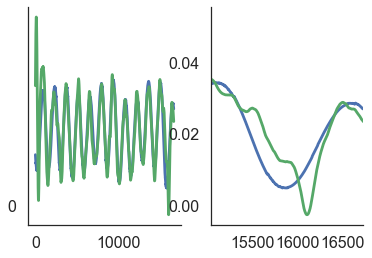

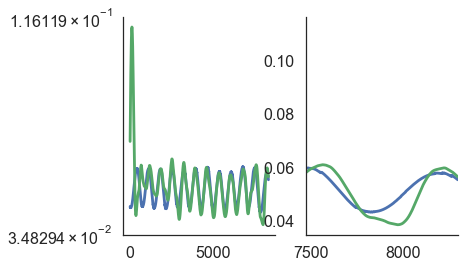

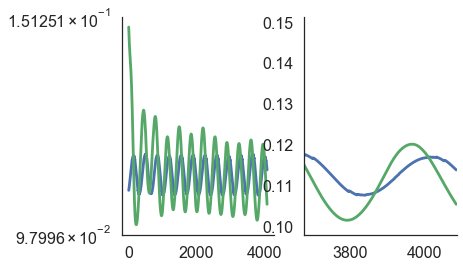

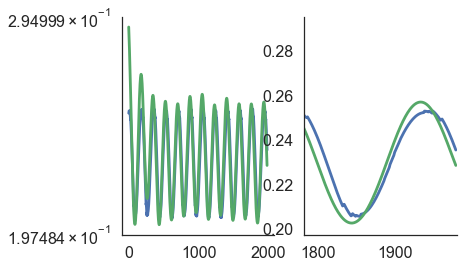

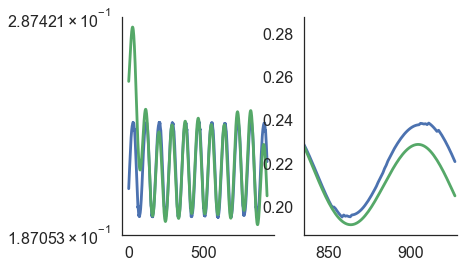

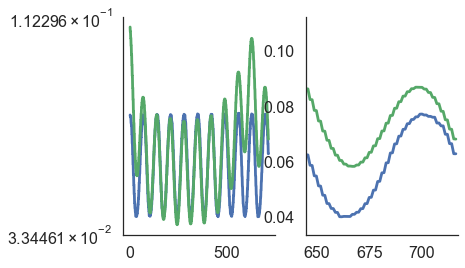

In [514]:
#Instantiate Model
model = get_mlp_logan(X_si)
epochs = 10

for df in dfs_si_train:
    (X_tr, y_tr) = get_data_columns(df)

    model, r = transfer_train(model, X_tr, y_tr,splits=[len(X_tr)], batch_size=50, epochs=epochs)

    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {}".format(sp,mae))
    summary_plots(preds, y_tr)

Stopping Power: 0.02082991972565651 
MAE: 0.003002725720774424 
Percent:0.1441544547613366
Stopping Power: 0.05074511840939522 
MAE: 0.004446673813872387 
Percent:0.08762761726158681
Stopping Power: 0.1074691191315651 
MAE: 0.0076268930924264025 
Percent:0.07096822933004095
Stopping Power: 0.22204916179180145 
MAE: 0.010863437633787556 
Percent:0.04892356965514408
Stopping Power: 0.22471877932548523 
MAE: 0.009069315003550828 
Percent:0.04035850955925107
Stopping Power: 0.072128064930439 
MAE: 0.010819771712000194 
Percent:0.15000779131444725


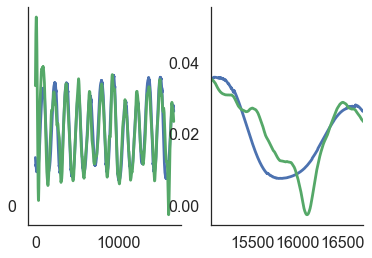

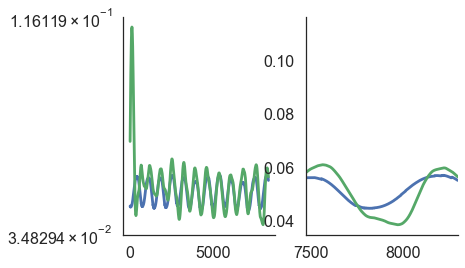

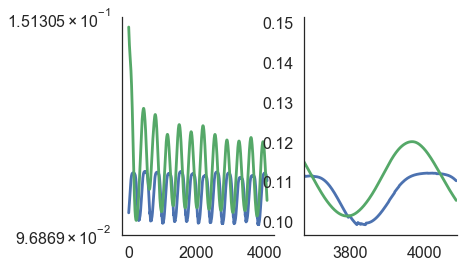

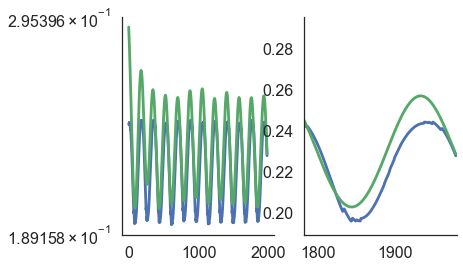

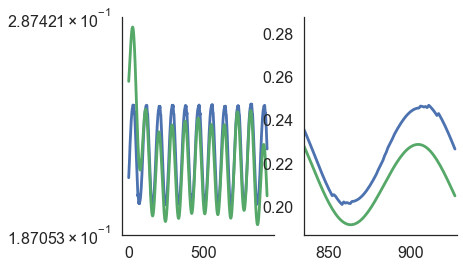

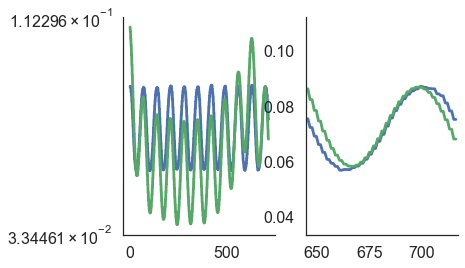

In [543]:
for df in dfs_si_train:
    (X_tr, y_tr) = get_data_columns(df)

    #model, r = transfer_train(model, X_tr, y_tr,splits=[int(len(X_tr)/10)], epochs=25)

    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {} \nPercent:{}".format(sp,mae, float(mae/sp)))
    summary_plots(preds, y_tr)

## Try training in random groups

Epoch 1/5
66723/66723 [==============================] - 9s - loss: 0.0130 - mean_absolute_error: 0.0130     
Epoch 2/5
66723/66723 [==============================] - 5s - loss: 0.0079 - mean_absolute_error: 0.0079     
Epoch 3/5
66723/66723 [==============================] - 6s - loss: 0.0073 - mean_absolute_error: 0.0073     
Epoch 4/5
66723/66723 [==============================] - 6s - loss: 0.0070 - mean_absolute_error: 0.0070     
Epoch 5/5
66723/66723 [==============================] - 6s - loss: 0.0069 - mean_absolute_error: 0.0069     
Stopping Power: 0.10779727250337601 
MAE: 0.008222592711749683


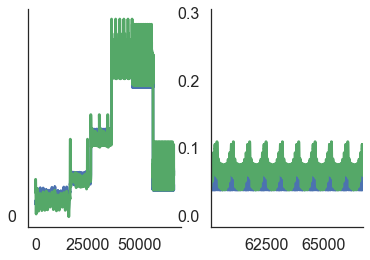

In [545]:
#Instantiate Model
model = get_mlp_logan(X_si)
epochs = 5
length = 10000

X_train = []
y_train = []
for df in dfs_si_train:
    (X_tr, y_tr) = get_data_columns(df)
    X_tr, y_tr = expand_class(X_tr, y_tr, length=length)
    X_train.append(X_tr)
    y_train.append(y_tr)

X_train = np.vstack(X_train) 
y_train = np.concatenate(y_train)


model, r = transfer_train(model, X_train, y_train,splits=[len(X_train)], batch_size=100,
                          epochs=epochs)

preds, mae, sp = predict_summarize([model], X_train, y_train)
print("Stopping Power: {} \nMAE: {}".format(sp,mae))
summary_plots(preds, y_train)

Stopping Power: 0.027331780642271042 
MAE: 0.007391161859458675 
Percent27.04237223398311
Stopping Power: 0.05450595170259476 
MAE: 0.005411654157819294 
Percent9.928556403064643
Stopping Power: 0.12063854932785034 
MAE: 0.008324319483118098 
Percent6.900215171268115
Stopping Power: 0.23318953812122345 
MAE: 0.005652495857185417 
Percent2.423992046438623
Stopping Power: 0.2126230001449585 
MAE: 0.00936987404587716 
Percent4.406801728641364
Stopping Power: 0.05271968990564346 
MAE: 0.012535299337855953 
Percent23.77726303074118


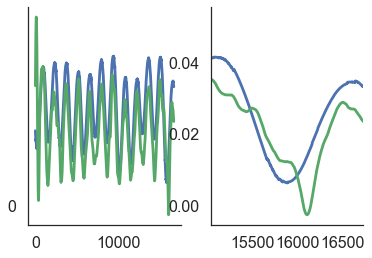

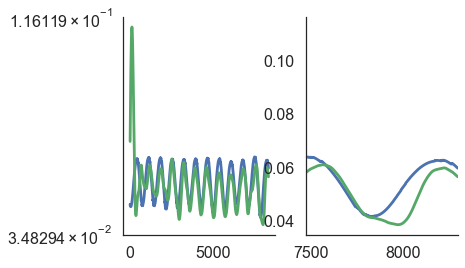

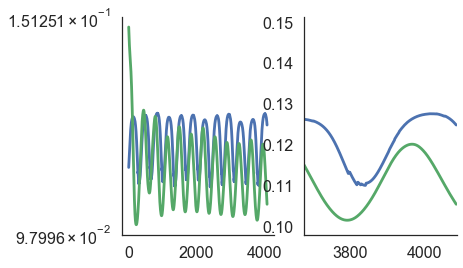

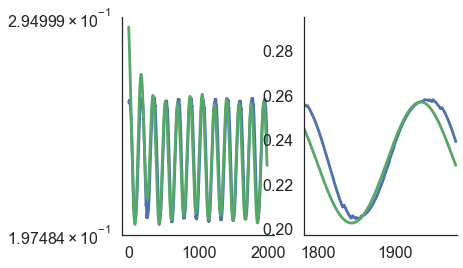

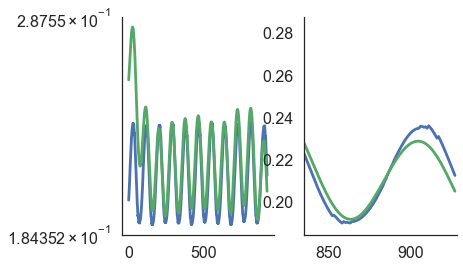

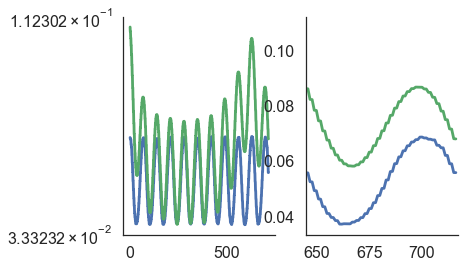

In [548]:
for df in dfs_si_train:
    (X_tr, y_tr) = get_data_columns(df)

    #model, r = transfer_train(model, X_tr, y_tr,splits=[int(len(X_tr)/10)], epochs=5)

    preds, mae, sp = predict_summarize([model], X_tr, y_tr)
    print("Stopping Power: {} \nMAE: {} \nPercent{}".format(sp,mae, 100*float(mae/sp)))
    summary_plots(preds, y_tr)

In [338]:
models = [(get_mlp_small(X_si), "Small MLP"), 
          (get_mlp_deep(X_si), "Deeper MLP"),
          (get_mlp_wide(X_si), "Wider MLP"), 
          (get_mlp_base(X_si), "Base MLP")]

splits = [4725]
epochs = 25
batch_size = 100
verbose = True
dfs = []
for model, model_name in models:
    model, r = train_over_times(model, X_si, y_si, splits, batch_size=batch_size, 
                                epochs=epochs, verbose=verbose)
    df_r = pd.DataFrame(r)
    df_r['model_name'] = model_name
    dfs.append(df_r)
mlp_results = pd.concat(dfs)
mlp_results

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_409 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_410 (Dense)            (None, 8)                 144       
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 9         
Total params: 459
Trainable params: 459
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
4725/4725 [==============================] - 2s - loss: 0.0100 - mean_absolute_error: 0.0100     
Epoch 2/25
4725/4725 [==============================] - 0s - loss: 0.0054 - mean_absolute_error: 0.0054     
Epoch 3/25
4725/4725 [==============================] - 0s - loss: 0.0053 - mean_absolute_error: 0.0053     
Epoch 4/25
4725/4725 [==============================] - 0s - loss: 0.0054 - 

4725/4725 [==============================] - 0s - loss: 0.0051 - mean_absolute_error: 0.0051     
Epoch 19/25
4725/4725 [==============================] - 0s - loss: 0.0053 - mean_absolute_error: 0.0053     
Epoch 20/25
4725/4725 [==============================] - 0s - loss: 0.0051 - mean_absolute_error: 0.0051     
Epoch 21/25
4725/4725 [==============================] - 0s - loss: 0.0051 - mean_absolute_error: 0.0051     
Epoch 22/25
4725/4725 [==============================] - 0s - loss: 0.0051 - mean_absolute_error: 0.0051     - ETA: 0s - loss: 0.0053 - mean_absolute_err
Epoch 23/25
4725/4725 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.005 - 0s - loss: 0.0051 - mean_absolute_error: 0.0051     
Epoch 24/25
4725/4725 [==============================] - 0s - loss: 0.0051 - mean_absolute_error: 0.0051     
Epoch 25/25
4725/4725 [==============================] - 0s - loss: 0.0050 - mean_absolute_error: 0.0050     
Epoch 1/25
4725/4725 [============

,batch_size,epochs,history,mae,model,pred_y,split,stopping_power,model_name
0,100,25,"{'loss': [0.0100400508283, 0.00542778368034, 0...",0.003952,<keras.models.Sequential object at 0x15ad90048>,"[[0.0161752], [0.0161342], [0.0160933], [0.016...",4725,0.022861,Small MLP
0,100,25,"{'loss': [0.0218681720721, 0.00546453411262, 0...",0.003168,<keras.models.Sequential object at 0x15e4a6f28>,"[[0.0140289], [0.0139827], [0.0139365], [0.013...",4725,0.021052,Deeper MLP
0,100,25,"{'loss': [0.0145938030528, 0.00631906294446, 0...",0.003523,<keras.models.Sequential object at 0x15ae633c8>,"[[0.0160038], [0.0159655], [0.0159274], [0.015...",4725,0.022276,Wider MLP
0,100,25,"{'loss': [0.0158764327058, 0.0062652848927, 0....",0.003462,<keras.models.Sequential object at 0x15b67c240>,"[[0.0132521], [0.0132075], [0.013163], [0.0131...",4725,0.019764,Base MLP


## Train-test split data

In [84]:
split = 4725
X_train, X_test, y_train, y_test = time_split(X, y, split)

In [17]:
n_models = 1
mlp_models = []
for i in range(0,n_models):
    model = get_mlp_model()
    hist = model.fit(X_train, y_train,epochs=50, batch_size=500, verbose=1)
    
    mlp_models.append(model)

Epoch 1/50
4725/4725 [==============================] - 0s - loss: 1.5018 - mean_absolute_error: 1.5018     
Epoch 2/50
4725/4725 [==============================] - 0s - loss: 0.9932 - mean_absolute_error: 0.9932     
Epoch 3/50
4725/4725 [==============================] - 0s - loss: 0.5080 - mean_absolute_error: 0.5080     
Epoch 4/50
4725/4725 [==============================] - 0s - loss: 0.3818 - mean_absolute_error: 0.3818     
Epoch 5/50
4725/4725 [==============================] - 0s - loss: 0.2384 - mean_absolute_error: 0.2384     
Epoch 6/50
4725/4725 [==============================] - 0s - loss: 0.1717 - mean_absolute_error: 0.1717     
Epoch 7/50
4725/4725 [==============================] - 0s - loss: 0.1209 - mean_absolute_error: 0.1209     
Epoch 8/50
4725/4725 [==============================] - 0s - loss: 0.1134 - mean_absolute_error: 0.1134     
Epoch 9/50
4725/4725 [==============================] - 0s - loss: 0.1216 - mean_absolute_error: 0.1216     
Epoch 10/50
4725/47

[(<keras.models.Sequential at 0x15ad90048>, 'Small MLP'),
 (<keras.models.Sequential at 0x15e4a6f28>, 'Deeper MLP'),
 (<keras.models.Sequential at 0x15ae633c8>, 'Wider MLP'),
 (<keras.models.Sequential at 0x15b67c240>, 'Base MLP')]

Stopping Power: 0.021488266065716743 
MAE: 0.0033134480231893147


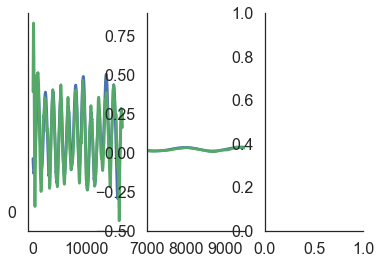

In [345]:
#models = [model for model, name in models]
preds, mae, sp = predict_summarize(models, X_si, y_si)
print("Stopping Power: {} \nMAE: {}".format(sp,mae))
summary_plots(preds, y_si)

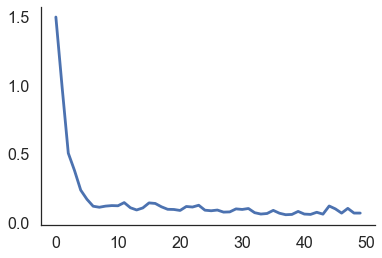

In [54]:
f,ax = plt.subplots()
ax = plt.plot(hist.history['loss'])
sns.despine()

# RNN Models

In [96]:
data = pd.read_csv('training_set.csv')
charge_attrs = [x for x in data.columns if x.startswith('density')]
agni_attrs = [x for x in data.columns if x.startswith('AGNI')]
ewald_attrs = ['ion-ion repulsion',]
y_col = 'force'
X_cols = charge_attrs + agni_attrs + ewald_attrs

In [97]:
def create_schleife_model(steps_before, steps_after, hidden_neurons, feature_count):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    #model.add(LSTM(output_dim=hidden_neurons, return_sequences=True))
    model.add(LSTM(output_dim=hidden_neurons, return_sequences=False))
    model.add(Dense(1))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
    print(model.summary())
    return model

def create_schleife_single_lstm_model(steps_before, steps_after, hidden_neurons, feature_count):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=hidden_neurons, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(Dense(1))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
    print(model.summary())
    return model

def create_schleife_simple_rnn_model2(hidden_neurons, feature_count, activation="relu", steps_after=1):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(RepeatVector(steps_after))
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(Dense(1))
    
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mae']) 
    print(model.summary())
    return model

def create_schleife_simple_rnn_model(hidden_neurons, feature_count, activation="relu"):
    """ 
        creates, compiles and returns a RNN model 
        @param steps_before: the number of previous time steps (input)
        @param steps_after: the number of posterior time steps (output or predictions)
        @param feature_count: the number of features in the model
        @param hidden_neurons: the number of hidden neurons per LSTM layer
    """
    out_neurons = 1
    
    model = Sequential()
    model.add(SimpleRNN(units=hidden_neurons, input_dim=feature_count, return_sequences=False, activation=activation))
    model.add(Dense(1))
    
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mae']) 
    print(model.summary())
    return model

def keras_schleife_reshape(data_x,data_y, n_pre, n_post):
    dX, dY = [], []
    for i in range(len(data_x)-n_pre-n_post):
        dX.append(data_x[i:i+n_pre])
        dY.append(data_y[i+n_pre:i+n_pre+n_post])

    dataX = np.array(dX)
    dataY = np.array(dY)
    return dataX, dataY

def train_schleife_model(model, dataX, dataY, epoch_count,validation_split=0.1, verbose=False):
    """ 
        trains only the sinus model
    """
    history = model.fit(dataX, dataY, batch_size=200, epochs=epoch_count, validation_split=validation_split, verbose=verbose)
    return history

In [99]:
n_pre= 5
n_post = 1
n_dim = 16

X_ = data[X_cols].as_matrix()
y_ = data[y_col].as_matrix()

X,y = keras_schleife_reshape(X_,y_, n_pre, n_post)
print("Data shapes \nX:{} \ny{}".format(X.shape, y.shape))

Data shapes 
X:(9443, 5, 16) 
y(9443, 1)


In [62]:
X.shape

(9443, 5, 16)

In [63]:
y.shape

(9443, 1)

In [84]:
# # # create and fit the LSTM network
print('creating model...')
models = []
n_models = 3
n_epochs = 20
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_model(n_pre, n_post, 100, 16)
    h = train_schleife_model(tmp_model, X, y, n_epochs)
    models.append(tmp_model)

creating model...
=== Model -- 0 ===


NameError: name 'LSTM' is not defined

In [65]:
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, SimpleRNN


split = 4725

X_train = X[0:split]
X_test = X[split:]

y_train = y[0:split]
y_test = y[split:]

activation = "linear"

print('creating model...')
models = []
n_models = 1
n_epochs = 20
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_simple_rnn_model2(10, 16, activation="linear")
    h = train_schleife_model(tmp_model, X_train, y_train, n_epochs, validation_split=0.0, verbose=True)
    models.append(tmp_model)

creating model...
=== Model -- 0 ===


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=10, return_sequences=False, activation="linear", input_shape=(None, 16))`
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=10, return_sequences=False, activation="linear", input_shape=(None, 16))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 10)                270       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 10)             0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
4725/4725 [==============================] - 2s - loss: 0.9940 - mean_absolute_error: 0.9940     
Epoch 2/20
4725/4725 [==============================] - 0s - loss: 0.4866 - mean_absolute_error: 0.4866     
Epoch 3/20
4725/4725 [==============================]

In [71]:
preds = composite_predict(models, X)

# preds = []
# for i in range(0,n_models):
#     print(i)
#     preds.append(models[i].predict(X))
# composite_pred = np.mean(preds, axis=0) 

In [109]:
mean_absolute_error(composite_pred, y)

0.036689993726125726

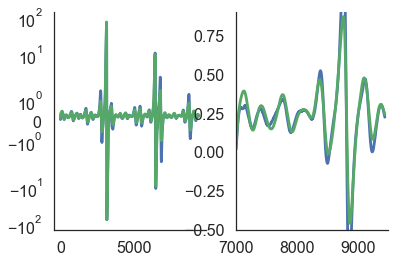

In [73]:
summary_plots(preds, y)

In [75]:
preds = composite_predict(models,X)
mlp_mae = mean_absolute_error(preds,y)
stopping_power = np.mean(preds)
print("Stopping Power: {} \nMAE: {}".format(stopping_power,mlp_mae))

Stopping Power: 0.23045514523983002 
MAE: 0.09728391782097477


(0, 0.2)

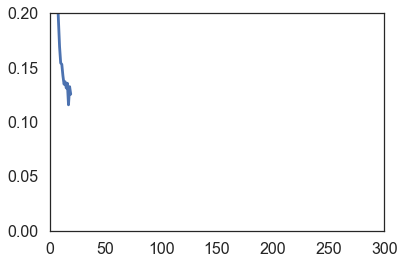

In [76]:
fig, ax = plt.subplots()
ax.plot(h.history['loss'])
ax.set_xlim(0,300)
ax.set_ylim(0,0.2)

In [175]:
# # # create and fit the LSTM network
print('creating model...')
models = []
n_models = 1
n_epochs = 10
for i in range(0,n_models):
    print("=== Model -- {} ===".format(i))
    tmp_model = create_schleife_single_lstm_model(n_pre, n_post, 500, 16)
    h = train_schleife_model(tmp_model, X, y, n_epochs)
    models.append(tmp_model)

creating model...
=== Model -- 0 ===


NameError: name 'LSTM' is not defined

(0, 0.2)

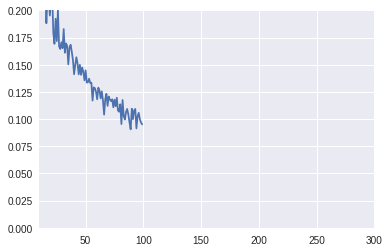